In [3]:
!pip install kaggle --quiet
!pip install polars --quiet
!pip install matplotlib --quiet
!pip install plotly --quiet
!pip install missingno --quiet

In [ ]:
## We will download the datset

In [11]:
! mkdir ~/.kaggle


In [12]:
! cp kaggle.json ~/.kaggle/


In [13]:
! chmod 600 ~/.kaggle/kaggle.json


In [14]:
! kaggle competitions download web-traffic-time-series-forecasting


100% 582M/583M [00:08<00:00, 103MB/s]
100% 583M/583M [00:08<00:00, 74.4MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip web-traffic-time-series-forecasting.zip -d train



Archive:  web-traffic-time-series-forecasting.zip
  inflating: train/key_1.csv.zip     
  inflating: train/key_2.csv.zip     
  inflating: train/sample_submission_1.csv.zip  
  inflating: train/sample_submission_2.csv.zip  
  inflating: train/train_1.csv.zip   
  inflating: train/train_2.csv.zip   


In [ ]:
! unzip train/train_1.csv.zip -d train


Archive:  train/train_1.csv.zip
  inflating: train/train_1.csv       


In [ ]:
## Importing the libraries

In [ ]:
import polars as pl
import numpy as np
import datetime
import pandas as pd
import missingno as msno
##matplotlib

from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
#import pdarima as pm

In [ ]:
import plotly

In [ ]:
df = pl.read_csv("train/train_1.csv",has_header=True,ignore_errors=True,infer_schema_length=10000)

In [ ]:
df.head()

shape: (5, 551)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ Page        ┆ 2015-07- ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-30 ┆ 2016-12-31 │
│ ---         ┆ 01       ┆ 02       ┆ 03       ┆   ┆ 28       ┆ 29       ┆ ---        ┆ ---        │
│ str         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ i64        ┆ i64        │
│             ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64      ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2NE1_zh.wik ┆ 18       ┆ 11       ┆ 5        ┆ … ┆ 22       ┆ 19       ┆ 18         ┆ 20         │
│ ipedia.org_ ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ all-access… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 2PM_zh.wiki ┆ 11       ┆ 14       ┆ 15       ┆ … ┆ 52       ┆ 45       ┆ 26         ┆ 20         │
│ pedia.org_a ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ll-access_… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 3C_zh.wikip ┆ 1        ┆ 0        ┆ 1        ┆ … ┆ 6        ┆ 3        ┆ 4          ┆ 17         │
│ edia.org_al ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ l-access_s… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 4minute_zh. ┆ 35       ┆ 13       ┆ 10       ┆ … ┆ 17       ┆ 19       ┆ 10         ┆ 11         │
│ wikipedia.o ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ rg_all-acc… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 52_Hz_I_Lov ┆ null     ┆ null     ┆ null     ┆ … ┆ 27       ┆ 13       ┆ 36         ┆ 10         │
│ e_You_zh.wi ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ kipedia.or… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
└─────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────┴────────────┘

In [ ]:
df.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [ ]:
df.describe()

shape: (9, 552)
┌─────────────┬────────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬────────────┐
│ describe    ┆ Page       ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-31 │
│ ---         ┆ ---        ┆ 01       ┆ 02       ┆   ┆ 28       ┆ 29       ┆ 30       ┆ ---        │
│ str         ┆ str        ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ f64        │
│             ┆            ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆            │
╞═════════════╪════════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪════════════╡
│ count       ┆ 145063     ┆ 145063.0 ┆ 145063.0 ┆ … ┆ 145063.0 ┆ 145063.0 ┆ 145063.0 ┆ 145063.0   │
│ null_count  ┆ 0          ┆ 20740.0  ┆ 20816.0  ┆ … ┆ 3822.0   ┆ 3826.0   ┆ 3635.0   ┆ 3465.0     │
│ mean        ┆ null       ┆ 1195.856 ┆ 1204.003 ┆ … ┆ 1633.965 ┆ 1684.307 ┆ 1467.943 ┆ 1478.28213 │
│             ┆            ┆ 567      ┆ 638      ┆   ┆ 605      ┆ 717      ┆ 378      ┆ 7          │
│ std         ┆ null       ┆ 72753.51 ┆ 74215.14 ┆ … ┆ 91858.30 ┆ 90142.65 ┆ 81554.81 ┆ 88735.6725 │
│             ┆            ┆ 8671     ┆ 5424     ┆   ┆ 7668     ┆ 6814     ┆ 4146     ┆ 89         │
│ min         ┆ !vote_en.w ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0        │
│             ┆ ikipedia.o ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ rg_all-acc ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ es…        ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│ max         ┆ ［Alexandr ┆ 2.038124 ┆ 2.075219 ┆ … ┆ 2.702505 ┆ 2.607381 ┆ 2.436396 ┆ 2.6149541e │
│             ┆ os］_ja.wi ┆ 5e7      ┆ 4e7      ┆   ┆ 3e7      ┆ 9e7      ┆ 7e7      ┆ 7          │
│             ┆ kipedia.or ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ g_mo…      ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│ median      ┆ null       ┆ 109.0    ┆ 108.0    ┆ … ┆ 163.0    ┆ 160.0    ┆ 154.0    ┆ 136.0      │
│ 25%         ┆ null       ┆ 13.0     ┆ 13.0     ┆ … ┆ 24.0     ┆ 23.0     ┆ 23.0     ┆ 21.0       │
│ 75%         ┆ null       ┆ 524.0    ┆ 519.0    ┆ … ┆ 654.0    ┆ 649.0    ┆ 635.0    ┆ 561.0      │
└─────────────┴────────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴────────────┘

<Axes: >

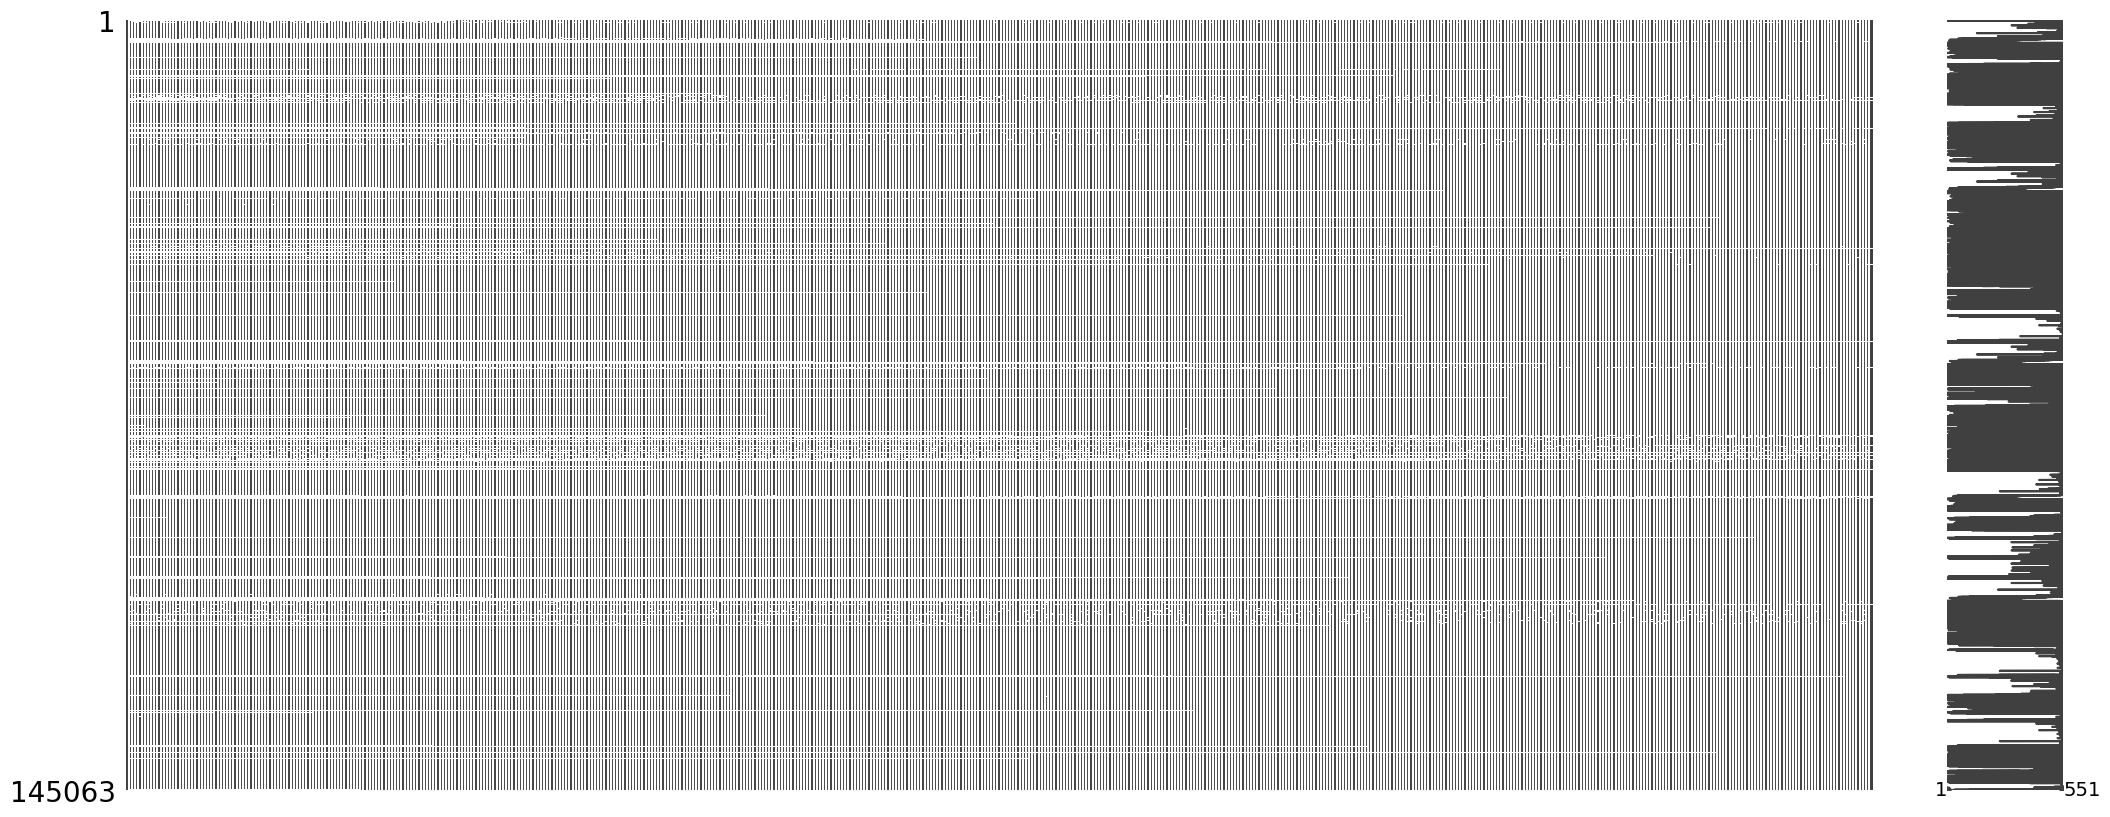

In [ ]:
msno.matrix(df.to_pandas())

<Axes: >

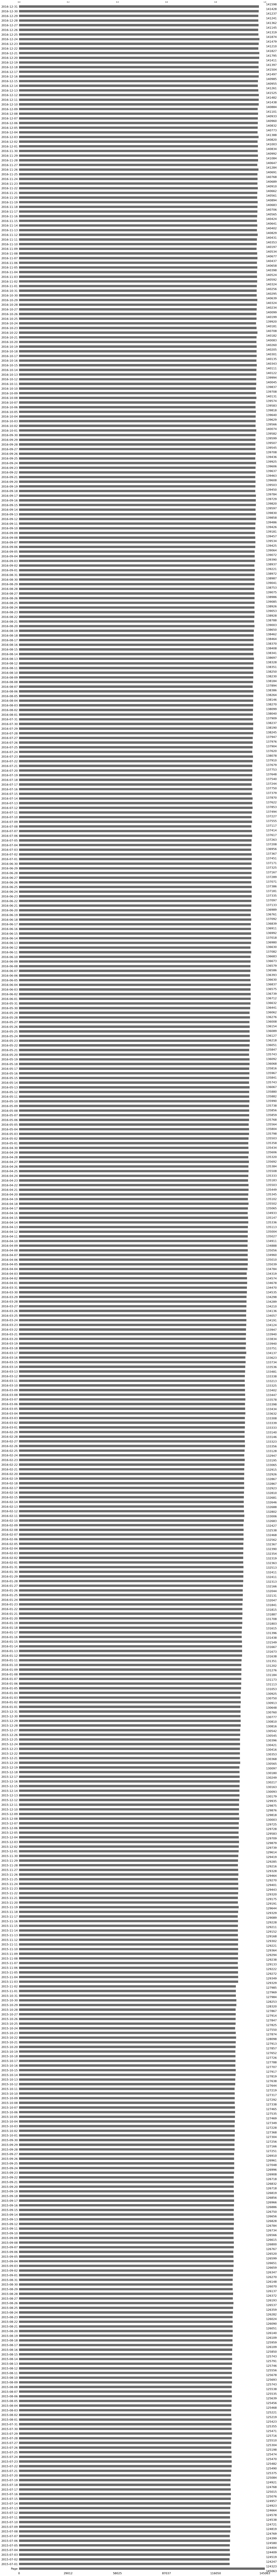

In [ ]:
msno.bar(df.to_pandas())

<Axes: >

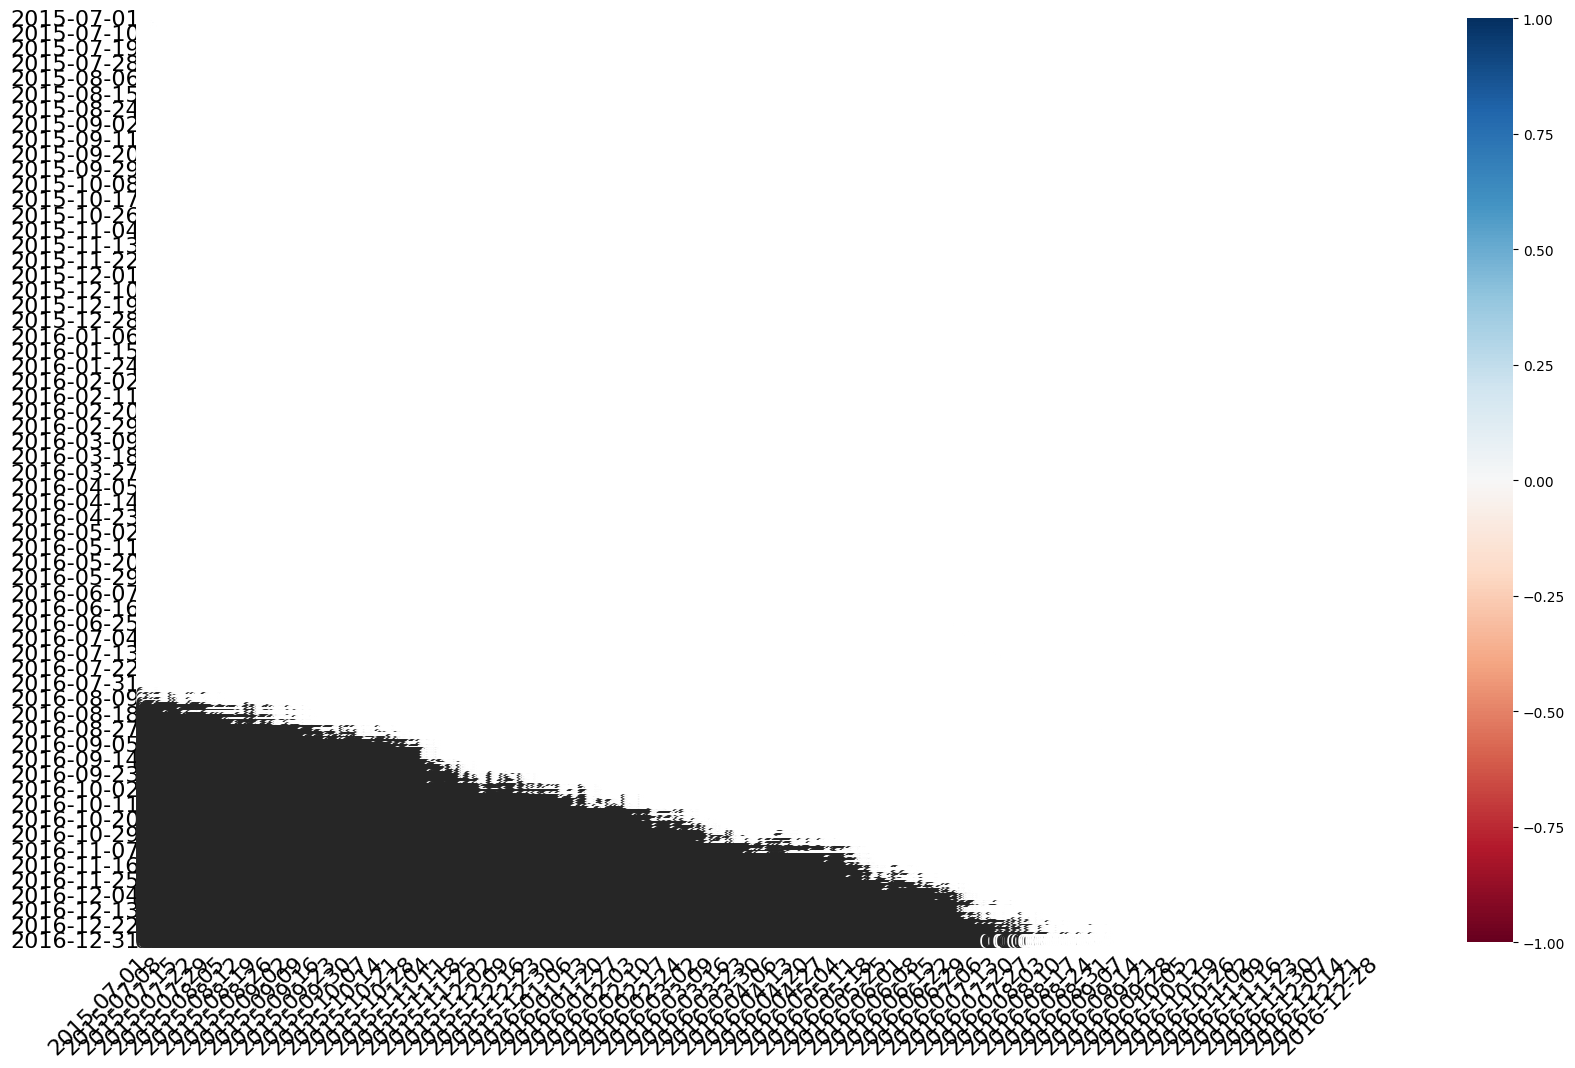

In [ ]:
msno.heatmap(df.to_pandas())


In [ ]:
##We are going to drop the null values for now

In [ ]:
df_without_nulls = df.select(pl.all()).drop_nulls()

In [ ]:
df_without_nulls.head(4)

shape: (4, 551)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ Page        ┆ 2015-07- ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-30 ┆ 2016-12-31 │
│ ---         ┆ 01       ┆ 02       ┆ 03       ┆   ┆ 28       ┆ 29       ┆ ---        ┆ ---        │
│ str         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ i64        ┆ i64        │
│             ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64      ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2NE1_zh.wik ┆ 18       ┆ 11       ┆ 5        ┆ … ┆ 22       ┆ 19       ┆ 18         ┆ 20         │
│ ipedia.org_ ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ all-access… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 2PM_zh.wiki ┆ 11       ┆ 14       ┆ 15       ┆ … ┆ 52       ┆ 45       ┆ 26         ┆ 20         │
│ pedia.org_a ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ll-access_… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 3C_zh.wikip ┆ 1        ┆ 0        ┆ 1        ┆ … ┆ 6        ┆ 3        ┆ 4          ┆ 17         │
│ edia.org_al ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ l-access_s… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 4minute_zh. ┆ 35       ┆ 13       ┆ 10       ┆ … ┆ 17       ┆ 19       ┆ 10         ┆ 11         │
│ wikipedia.o ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ rg_all-acc… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
└─────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────┴────────────┘

In [ ]:
len(df_without_nulls['Page'])

117276

<h4> We will first 10 pages . As we have limited computations power

In [ ]:
df_without_nulls_top = df_without_nulls[:10,:]

In [ ]:
df_without_nulls_top

shape: (10, 551)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ Page        ┆ 2015-07- ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-30 ┆ 2016-12-31 │
│ ---         ┆ 01       ┆ 02       ┆ 03       ┆   ┆ 28       ┆ 29       ┆ ---        ┆ ---        │
│ str         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ i64        ┆ i64        │
│             ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64      ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2NE1_zh.wik ┆ 18       ┆ 11       ┆ 5        ┆ … ┆ 22       ┆ 19       ┆ 18         ┆ 20         │
│ ipedia.org_ ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ all-access… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 2PM_zh.wiki ┆ 11       ┆ 14       ┆ 15       ┆ … ┆ 52       ┆ 45       ┆ 26         ┆ 20         │
│ pedia.org_a ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ll-access_… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 3C_zh.wikip ┆ 1        ┆ 0        ┆ 1        ┆ … ┆ 6        ┆ 3        ┆ 4          ┆ 17         │
│ edia.org_al ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ l-access_s… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 4minute_zh. ┆ 35       ┆ 13       ┆ 10       ┆ … ┆ 17       ┆ 19       ┆ 10         ┆ 11         │
│ wikipedia.o ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ rg_all-acc… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ …           ┆ …        ┆ …        ┆ …        ┆ … ┆ …        ┆ …        ┆ …          ┆ …          │
│ AKB48_zh.wi ┆ 5        ┆ 23       ┆ 14       ┆ … ┆ 36       ┆ 38       ┆ 31         ┆ 97         │
│ kipedia.org ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ _all-acces… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ASCII_zh.wi ┆ 6        ┆ 3        ┆ 5        ┆ … ┆ 35       ┆ 44       ┆ 26         ┆ 41         │
│ kipedia.org ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ _all-acces… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ Ahq_e-Sport ┆ 2        ┆ 1        ┆ 4        ┆ … ┆ 9        ┆ 23       ┆ 11         ┆ 7          │
│ s_Club_zh.w ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ikipedia.o… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ All_your_ba ┆ 2        ┆ 5        ┆ 5        ┆ … ┆ 7        ┆ 4        ┆ 5          ┆ 0          │
│ se_are_belo ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ng_to_us_z… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
└─────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────┴────────────┘

In [ ]:
df_without_nulls_top.describe()

shape: (9, 552)
┌─────────────┬────────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬────────────┐
│ describe    ┆ Page       ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-31 │
│ ---         ┆ ---        ┆ 01       ┆ 02       ┆   ┆ 28       ┆ 29       ┆ 30       ┆ ---        │
│ str         ┆ str        ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ f64        │
│             ┆            ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆            │
╞═════════════╪════════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪════════════╡
│ count       ┆ 10         ┆ 10.0     ┆ 10.0     ┆ … ┆ 10.0     ┆ 10.0     ┆ 10.0     ┆ 10.0       │
│ null_count  ┆ 0          ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0        │
│ mean        ┆ null       ┆ 21.0     ┆ 10.3     ┆ … ┆ 23.9     ┆ 25.1     ┆ 18.0     ┆ 28.0       │
│ std         ┆ null       ┆ 35.58713 ┆ 8.90755  ┆ … ┆ 14.92537 ┆ 15.60235 ┆ 10.39230 ┆ 28.476111  │
│             ┆            ┆ 9        ┆          ┆   ┆          ┆          ┆ 5        ┆            │
│ min         ┆ 2NE1_zh.wi ┆ 1.0      ┆ 0.0      ┆ … ┆ 6.0      ┆ 3.0      ┆ 4.0      ┆ 0.0        │
│             ┆ kipedia.or ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ g_all-acce ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ ss…        ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│ max         ┆ All_your_b ┆ 118.0    ┆ 26.0     ┆ … ┆ 52.0     ┆ 45.0     ┆ 32.0     ┆ 97.0       │
│             ┆ ase_are_be ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ long_to_us ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│             ┆ _z…        ┆          ┆          ┆   ┆          ┆          ┆          ┆            │
│ median      ┆ null       ┆ 8.5      ┆ 9.0      ┆ … ┆ 22.5     ┆ 21.0     ┆ 17.5     ┆ 18.5       │
│ 25%         ┆ null       ┆ 2.0      ┆ 3.0      ┆ … ┆ 9.0      ┆ 17.0     ┆ 10.0     ┆ 11.0       │
│ 75%         ┆ null       ┆ 18.0     ┆ 14.0     ┆ … ┆ 35.0     ┆ 39.0     ┆ 26.0     ┆ 41.0       │
└─────────────┴────────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴────────────┘

In [ ]:
## Visulization

In [ ]:
%matplotlib inline
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [ ]:
plt.figure(figsize=(15,7))


<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

In [ ]:
df_without_nulls_top.head(2)

shape: (2, 551)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ Page        ┆ 2015-07- ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-30 ┆ 2016-12-31 │
│ ---         ┆ 01       ┆ 02       ┆ 03       ┆   ┆ 28       ┆ 29       ┆ ---        ┆ ---        │
│ str         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ i64        ┆ i64        │
│             ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64      ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2NE1_zh.wik ┆ 18       ┆ 11       ┆ 5        ┆ … ┆ 22       ┆ 19       ┆ 18         ┆ 20         │
│ ipedia.org_ ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ all-access… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 2PM_zh.wiki ┆ 11       ┆ 14       ┆ 15       ┆ … ┆ 52       ┆ 45       ┆ 26         ┆ 20         │
│ pedia.org_a ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ll-access_… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
└─────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────┴────────────┘

## We are going to implment magic

In [ ]:
web_traffic = df_without_nulls_top

In [ ]:
web_traffic_rows =  web_traffic.columns[1:]

In [ ]:
print(web_traffic_rows)

['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11', '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16', '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20', '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24', '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28', '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09', '2015

In [ ]:
web_traffic.head(2)

shape: (2, 551)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ Page        ┆ 2015-07- ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-30 ┆ 2016-12-31 │
│ ---         ┆ 01       ┆ 02       ┆ 03       ┆   ┆ 28       ┆ 29       ┆ ---        ┆ ---        │
│ str         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ i64        ┆ i64        │
│             ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64      ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2NE1_zh.wik ┆ 18       ┆ 11       ┆ 5        ┆ … ┆ 22       ┆ 19       ┆ 18         ┆ 20         │
│ ipedia.org_ ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ all-access… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 2PM_zh.wiki ┆ 11       ┆ 14       ┆ 15       ┆ … ┆ 52       ┆ 45       ┆ 26         ┆ 20         │
│ pedia.org_a ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ll-access_… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
└─────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────┴────────────┘

In [ ]:
### We are going to plot the graphs

In [ ]:
##pages

In [ ]:
web_traffic_pages = web_traffic['Page']

In [ ]:
web_traffic_rows[1]

'2015-07-02'

In [ ]:
print(web_traffic_pages)

shape: (10,)
Series: 'Page' [str]
[
	"2NE1_zh.wikipe…
	"2PM_zh.wikiped…
	"3C_zh.wikipedi…
	"4minute_zh.wik…
	"5566_zh.wikipe…
	"A'N'D_zh.wikip…
	"AKB48_zh.wikip…
	"ASCII_zh.wikip…
	"Ahq_e-Sports_C…
	"All_your_base_…
]


In [ ]:
web_traffic.head(2)

shape: (2, 551)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ Page        ┆ 2015-07- ┆ 2015-07- ┆ 2015-07- ┆ … ┆ 2016-12- ┆ 2016-12- ┆ 2016-12-30 ┆ 2016-12-31 │
│ ---         ┆ 01       ┆ 02       ┆ 03       ┆   ┆ 28       ┆ 29       ┆ ---        ┆ ---        │
│ str         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ i64        ┆ i64        │
│             ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64      ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2NE1_zh.wik ┆ 18       ┆ 11       ┆ 5        ┆ … ┆ 22       ┆ 19       ┆ 18         ┆ 20         │
│ ipedia.org_ ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ all-access… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ 2PM_zh.wiki ┆ 11       ┆ 14       ┆ 15       ┆ … ┆ 52       ┆ 45       ┆ 26         ┆ 20         │
│ pedia.org_a ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
│ ll-access_… ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
└─────────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────┴────────────┘

In [ ]:
web_traffic[1,1:].to_pandas().to_numpy().reshape(1,550)

In [ ]:
dates = web_traffic.columns

In [ ]:
dates.pop(0)

'Page'

In [ ]:
print(dates)

['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11', '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16', '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20', '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24', '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28', '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09', '2015

In [ ]:
web_traffic_pages.to_pandas().to_numpy()

array(['2NE1_zh.wikipedia.org_all-access_spider',
       '2PM_zh.wikipedia.org_all-access_spider',
       '3C_zh.wikipedia.org_all-access_spider',
       '4minute_zh.wikipedia.org_all-access_spider',
       '5566_zh.wikipedia.org_all-access_spider',
       "A'N'D_zh.wikipedia.org_all-access_spider",
       'AKB48_zh.wikipedia.org_all-access_spider',
       'ASCII_zh.wikipedia.org_all-access_spider',
       'Ahq_e-Sports_Club_zh.wikipedia.org_all-access_spider',
       'All_your_base_are_belong_to_us_zh.wikipedia.org_all-access_spider'],
      dtype=object)

Text(0, 0.5, 'web trafic on Page 1')

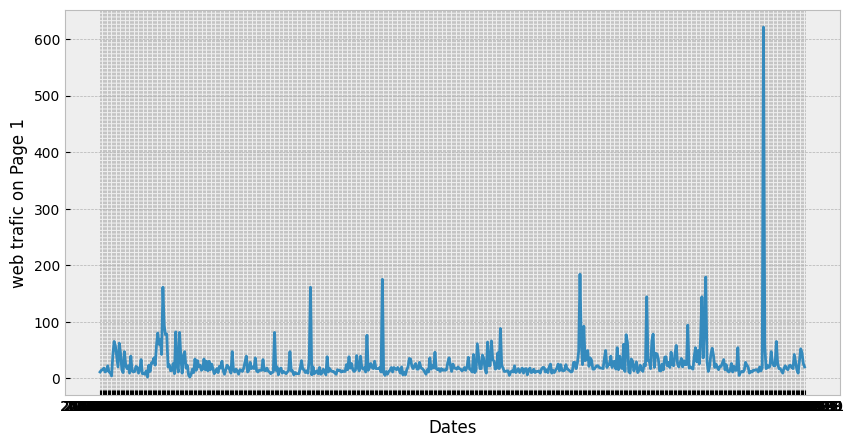

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(10,5))
plt.plot(dates,web_traffic[1,1:].to_pandas().to_numpy().reshape(550,))
plt.xlabel("Dates")
plt.ylabel(f"web trafic on Page 1")


Text(0, 0.5, 'web trafic on Page 2')

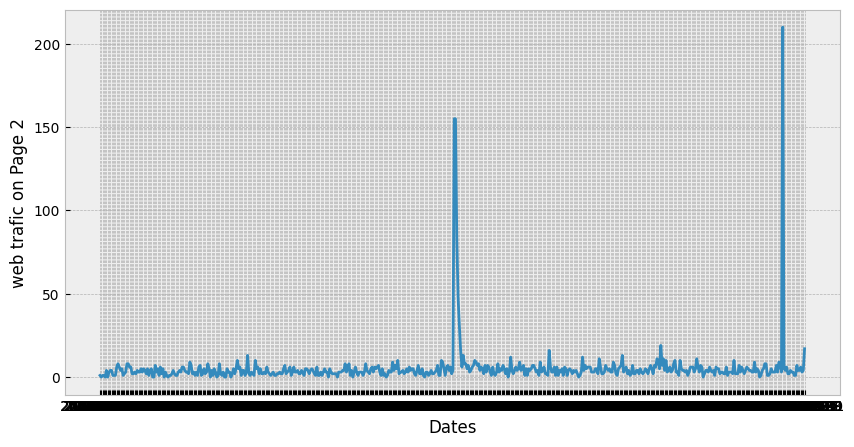

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(10,5))
plt.plot(dates,web_traffic[2,1:].to_pandas().to_numpy().reshape(550,))
plt.xlabel("Dates")
plt.ylabel(f"web trafic on Page 2")


Text(0, 0.5, 'web trafic on Page 3')

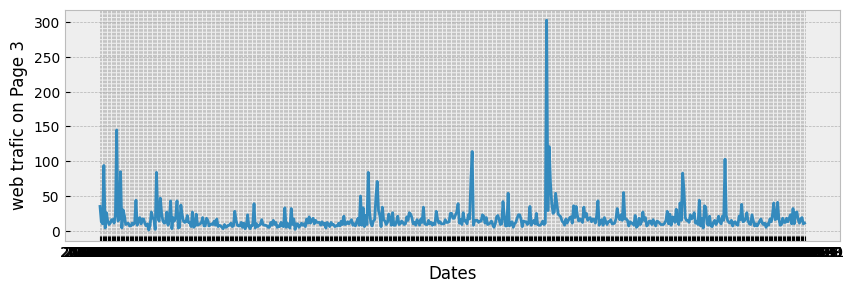

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(10,3))
plt.plot(dates,web_traffic[3,1:].to_pandas().to_numpy().reshape(550,))
plt.xlabel("Dates")
plt.ylabel(f"web trafic on Page 3")

In [ ]:
web_traffic_rows[1]

'2015-07-02'

In [ ]:
web_traffic_rows[1]

'2015-07-02'

shape: (10,)
Series: '2015-07-02' [i64]
[
	11
	14
	0
	13
	7
	26
	23
	3
	1
	5
]